# Preliminary Look and Clustering News Sources

Junita Sirait

I would like to cluster news sources based on in which subreddits they appear. First I will use k-means algorithm, then I will try out other algorithms such as DBSCAN and others. 

In [1]:
!pip install kneed

  Using cached kneed-0.7.0-py2.py3-none-any.whl (9.4 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)


In [6]:
!pip3 install sklearn

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for sklearn, since package 'wheel' is not installed.
    Running setup.py install for sklearn: started
    Running setup.py install for sklearn: finished with status 'done'


In [169]:
import json
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing

from sklearn.metrics import silhouette_score
from kneed import KneeLocator

from scipy.interpolate import make_interp_spline, BSpline

from sklearn.decomposition import PCA

import math

In [204]:
with open("ns_subreddit_2021-04.json", "r", encoding = "utf-8") as infile:
    ns_subreddit = json.load(infile)

How many news sources are there?

In [205]:
num_ns = len(ns_subreddit)
num_ns

3686

Let's see the data structure for `nytimes.com`

In [206]:
Counter(ns_subreddit['nytimes.com']).most_common(20)

[('nytimes', 5322),
 ('NYTauto', 3798),
 ('AutoNewspaper', 3788),
 ('TrendingQuickTVnews', 1454),
 ('politics', 775),
 ('news', 435),
 ('u_NumerousRow', 322),
 ('worldnews', 261),
 ('Coronavirus', 243),
 ('NoFilterNews', 211),
 ('FreshNewsToday', 198),
 ('u_somuchinfook', 197),
 ('u_Music908', 188),
 ('ScienceFeed', 170),
 ('autotldr', 167),
 ('AnythingGoesNews', 155),
 ('bitstreetpost', 132),
 ('neoliberal', 122),
 ('badgovnofreedom', 109),
 ('NoNewNormal', 77)]

For each news source, let's count in how many subreddits they appear

In [207]:
subreddit_count = dict()
for ns in ns_subreddit:
    subreddit_count[ns] = len(ns_subreddit[ns].keys())

`subreddit_count` stores in how many subreddits each news source appears.

In [208]:
subreddit_count['nytimes.com']

2174

In [209]:
subreddit_count_freq = dict(Counter(subreddit_count.values()).most_common())
subreddit_count_freq

{1: 675,
 2: 440,
 3: 315,
 4: 233,
 5: 162,
 6: 135,
 7: 132,
 8: 119,
 9: 95,
 10: 89,
 13: 69,
 12: 66,
 11: 62,
 17: 45,
 16: 44,
 14: 41,
 18: 37,
 15: 37,
 23: 37,
 20: 33,
 22: 32,
 19: 29,
 21: 25,
 27: 25,
 26: 25,
 25: 24,
 24: 19,
 44: 18,
 34: 18,
 28: 17,
 45: 17,
 33: 17,
 30: 16,
 29: 15,
 41: 15,
 40: 14,
 32: 14,
 31: 13,
 36: 13,
 39: 13,
 51: 11,
 61: 10,
 46: 10,
 50: 10,
 37: 9,
 38: 9,
 53: 8,
 42: 8,
 62: 7,
 43: 7,
 72: 7,
 60: 6,
 81: 6,
 56: 6,
 113: 6,
 35: 6,
 64: 6,
 55: 6,
 58: 5,
 47: 5,
 48: 5,
 117: 5,
 52: 5,
 73: 5,
 104: 5,
 105: 5,
 57: 5,
 63: 5,
 66: 5,
 67: 4,
 82: 4,
 83: 4,
 94: 4,
 85: 4,
 49: 4,
 78: 4,
 71: 4,
 86: 3,
 76: 3,
 54: 3,
 223: 3,
 202: 3,
 59: 3,
 89: 3,
 154: 3,
 125: 3,
 100: 3,
 84: 3,
 88: 3,
 92: 3,
 70: 3,
 65: 3,
 99: 2,
 102: 2,
 159: 2,
 146: 2,
 75: 2,
 74: 2,
 331: 2,
 114: 2,
 193: 2,
 150: 2,
 69: 2,
 90: 2,
 222: 2,
 98: 2,
 106: 2,
 149: 2,
 168: 2,
 80: 2,
 192: 2,
 108: 2,
 132: 2,
 361: 2,
 153: 2,
 95: 2,
 128

`subreddit_count_freq` keeps track of how many news sources appear in *n* subreddits for all possible *n*.

In [210]:
max(subreddit_count_freq.keys())

2174

Wow! There is a news source that appears in 2174 subreddits. This is `nytimes.com`.

In [211]:
for ns in ns_subreddit:
    count = subreddit_count[ns]
    if count > 1000:
        print(f"{ns} appears in {count} subreddits.")

cnbc.com appears in 1247 subreddits.
bbc.co.uk appears in 1095 subreddits.
reuters.com appears in 1538 subreddits.
nytimes.com appears in 2174 subreddits.
nbcnews.com appears in 1056 subreddits.
cnn.com appears in 1510 subreddits.
apnews.com appears in 1193 subreddits.
linkedin.com appears in 1506 subreddits.
washingtonpost.com appears in 1306 subreddits.
anchor.fm appears in 1049 subreddits.


Not sure why `cnbc.com` appears in so many subreddits. Canada! Linkedin appears a lot too, people sharing about themselves? But anonymous?

## Cluster Try Out

First, I make a list of subreddits with fixed order.

In [212]:
with open("subreddit_ns_2021-04.json", "r", encoding = "utf-8") as infile:
    subreddit_ns = json.load(infile)

In [213]:
subreddits = list(subreddit_ns.keys())
len(subreddits)

20755

There are 20755 subreddits.

In [214]:
subreddits[:10]

['razorbacks',
 'todayilearned',
 'nofeenews',
 'newsokur',
 'Ecatepec',
 'AntiHateCommunities',
 'anime',
 'worldnews',
 'TickerNews',
 'DeFiBuzz']

If I should order them later, I can do so.

# ** I added things here **

In [215]:
# Let's only use the subreddits that have lots of subscribers
with open ("subreddit_subscribers.json", "r", encoding = "utf-8") as infile:
    subreddit_subscribers = json.load(infile)

In [216]:
subreddit_subscribers['todayilearned']

23030716

In [217]:
len(subreddit_subscribers)

14595

In [218]:
len(subreddits)

20755

In [219]:
subreddits_w_subc = [subreddits[k] for k in range(len(subreddits)) if subreddits[k] in subreddit_subscribers]
len(subreddits_w_subc)

14595

It seems that there are `None` values, so let's filter those subreddits out.

In [220]:
print([s for s in subreddits_w_subc if subreddit_subscribers[s] is None])

['LoveForLandlords', 'RedditMobTest', 'StreetsIsWatchin', 'FisherFamilyMurders', 'DystopianFuture']


In [221]:
subreddits_w_subc = [s for s in subreddits_w_subc if subreddit_subscribers[s] is not None]

In [222]:
len(subreddits_w_subc)

14590

Now, I will sort the 14,590 subreddits based on the # of their subscribers in a descending order.

In [223]:
srs_all = sorted(subreddits_w_subc, key= lambda x: subreddit_subscribers[x], reverse= True)

(array([1.4075e+04, 2.4000e+01, 4.0000e+00, 1.0000e+00, 1.0000e+01,
        1.5000e+01, 7.0000e+00, 6.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([1.00000000e+00, 3.10601750e+06, 6.21203400e+06, 9.31805050e+06,
        1.24240670e+07, 1.55300835e+07, 1.86361000e+07, 2.17421165e+07,
        2.48481330e+07, 2.79541495e+07, 3.10601660e+07]),
 <BarContainer object of 10 artists>)

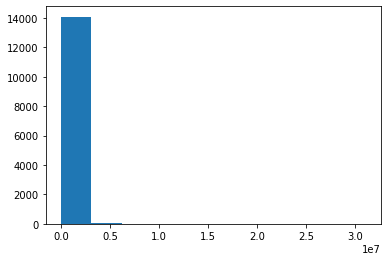

In [224]:
plt.hist([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s] > 0])
# log scale for both x and y

In [225]:
dir(math)

['__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'acos',
 'acosh',
 'asin',
 'asinh',
 'atan',
 'atan2',
 'atanh',
 'ceil',
 'comb',
 'copysign',
 'cos',
 'cosh',
 'degrees',
 'dist',
 'e',
 'erf',
 'erfc',
 'exp',
 'expm1',
 'fabs',
 'factorial',
 'floor',
 'fmod',
 'frexp',
 'fsum',
 'gamma',
 'gcd',
 'hypot',
 'inf',
 'isclose',
 'isfinite',
 'isinf',
 'isnan',
 'isqrt',
 'lcm',
 'ldexp',
 'lgamma',
 'log',
 'log10',
 'log1p',
 'log2',
 'modf',
 'nan',
 'nextafter',
 'perm',
 'pi',
 'pow',
 'prod',
 'radians',
 'remainder',
 'sin',
 'sinh',
 'sqrt',
 'tan',
 'tanh',
 'tau',
 'trunc',
 'ulp']

In [226]:
list(subreddit_subscribers.values()).count(None)

5

In [227]:
np.mean(np.array([k for k in list(subreddit_subscribers.values()) if k is not None]))

121403.32302947225

## Clusterings using 1000 subreddits

In [228]:
srs = srs_all[:1000]

First, I will incorporate data from the other two months

In [229]:
a = {"a": 1, "b": 2}
b = {"b": 1, "c": 2}
res = {**a, **b}
res

{'a': 1, 'b': 1, 'c': 2}

### Let's use data from 6 months

In [230]:
with open("ns_subreddit_2021-01.json", "r", encoding = "utf-8") as infile1:
    ns_subreddit_jan = json.load(infile1)

with open("ns_subreddit_2021-02.json", "r", encoding = "utf-8") as infile2:
    ns_subreddit_feb = json.load(infile2)
    
with open("ns_subreddit_2021-03.json", "r", encoding = "utf-8") as infile3:
    ns_subreddit_march = json.load(infile3)
    
with open("ns_subreddit_2021-05.json", "r", encoding = "utf-8") as infile5:
    ns_subreddit_may = json.load(infile5)
    
with open("ns_subreddit_2021-02.json", "r", encoding = "utf-8") as infile6:
    ns_subreddit_jun = json.load(infile6)

In [231]:
print(f'''
    #subreddits from
        jan: {len(ns_subreddit_jan)},
        feb: {len(ns_subreddit_feb)},
        march: {len(ns_subreddit_march)},
        april: {len(ns_subreddit)},
        may: {len(ns_subreddit_may)},
        june: {len(ns_subreddit_jun)}
    ''')


    #subreddits from
        jan: 3684,
        feb: 3678,
        march: 3700,
        april: 3686,
        may: 3652,
        june: 3678
    


For each news source, I create a list of length 1000 (# subreddits), and the values would be the count of how many times that news source appears in subreddit index *i*, where the index is based on the list `srs`.

In [232]:
ns_sr_rep = dict()
for ns in ns_subreddit:
    # the representation of a news source = # mentions in each subreddit
    ns_subreddit[ns] = Counter(ns_subreddit[ns])
    # ns_sr_rep[ns] = [ns_subreddit[ns][srs[idx]] if srs[idx] in ns_subreddit[ns] else 0 for idx in range(len(srs))]
    ns_sr_rep[ns] = [ns_subreddit[ns][srs[idx]] for idx in range(len(srs))]

# added Nov 13

# january
for ns_jan in ns_subreddit_jan:
    ns_subreddit_jan[ns_jan] = Counter(ns_subreddit_jan[ns_jan])
    if ns_jan in ns_sr_rep:
        # update
        ns_sr_rep[ns_jan] = [ns_sr_rep[ns_jan][idx] + ns_subreddit_jan[ns_jan][srs[idx]] 
                             # if srs[idx] in ns_subreddit_jan[ns_jan]
                             # else ns_sr_rep[ns_jan][idx] 
                             for idx in range(len(srs))]   
    else:
        ns_sr_rep[ns_jan] = [ns_subreddit_jan[ns_jan][srs[idx]] 
                             # if srs[idx] in ns_subreddit_jan[ns_jan] 
                             # else 0 
                             for idx in range(len(srs))]

# february
for ns_feb in ns_subreddit_feb:
    ns_subreddit_feb[ns_feb] = Counter(ns_subreddit_feb[ns_feb])
    if ns_feb in ns_sr_rep:
        ns_sr_rep[ns_feb] = [ns_sr_rep[ns_feb][idx] + ns_subreddit_feb[ns_feb][srs[idx]] 
                             # if srs[idx] in ns_subreddit_feb[ns_feb]
                             # else ns_sr_rep[ns_feb][idx] 
                             for idx in range(len(srs))]   
    else:
        ns_sr_rep[ns_feb] = [ns_subreddit_feb[ns_feb][srs[idx]] 
                             # if srs[idx] in ns_subreddit_feb[ns_feb] 
                             # else 0 
                             for idx in range(len(srs))]

# march
for ns_march in ns_subreddit_march:
    ns_subreddit_march[ns_march] = Counter(ns_subreddit_march[ns_march])
    if ns_march in ns_sr_rep:
        ns_sr_rep[ns_march] = [ns_sr_rep[ns_march][idx] + ns_subreddit_march[ns_march][srs[idx]] 
                               # if srs[idx] in ns_subreddit_march[ns_march] 
                               # else ns_sr_rep[ns_march][idx] 
                               for idx in range(len(srs))]   
    else:
        ns_sr_rep[ns_march] = [ns_subreddit_march[ns_march][srs[idx]] 
                             # if srs[idx] in ns_subreddit_march[ns_march] 
                             # else 0 
                             for idx in range(len(srs))]
     

    
# may
for ns_may in ns_subreddit_may:
    ns_subreddit_may[ns_may] = Counter(ns_subreddit_may[ns_may])
    if ns_may in ns_sr_rep:
        ns_sr_rep[ns_may] = [ns_sr_rep[ns_may][idx] + ns_subreddit_may[ns_may][srs[idx]] 
                             # if srs[idx] in ns_subreddit_may[ns_may]
                             # else ns_sr_rep[ns_may][idx] 
                             for idx in range(len(srs))]   
    else:
        ns_sr_rep[ns_may] = [ns_subreddit_may[ns_may][srs[idx]] 
                             # if srs[idx] in ns_subreddit_may[ns_may] 
                             # else 0 
                             for idx in range(len(srs))]
        
# june
for ns_jun in ns_subreddit_jun:
    ns_subreddit_jun[ns_jun] = Counter(ns_subreddit_jun[ns_jun])
    if ns_jun in ns_sr_rep:
        ns_sr_rep[ns_jun] = [ns_sr_rep[ns_jun][idx] + ns_subreddit_jun[ns_jun][srs[idx]] 
                             # if srs[idx] in ns_subreddit_jun[ns_jun]
                             # else ns_sr_rep[ns_jun][idx] 
                             for idx in range(len(srs))]   
    else:
        ns_sr_rep[ns_jun] = [ns_subreddit_jun[ns_jun][srs[idx]] 
                             # if srs[idx] in ns_subreddit_jun[ns_jun] 
                             # else 0 
                             for idx in range(len(srs))]

Let's see one example of representation for `nytimes.com`.

In [233]:
len(ns_sr_rep['nytimes.com'])

1000

In [71]:
ns_sr_rep['nytimes.com']

[8,
 8,
 7,
 2,
 79,
 1384,
 33,
 11,
 106,
 429,
 2844,
 2,
 19,
 0,
 1,
 3,
 0,
 2,
 99,
 3,
 13,
 0,
 31,
 442,
 67,
 4,
 93,
 14,
 0,
 0,
 122,
 0,
 4,
 27,
 9,
 99,
 0,
 33,
 8,
 0,
 0,
 66,
 1,
 280,
 0,
 1,
 9,
 6096,
 39,
 6,
 0,
 12,
 2,
 13,
 0,
 0,
 4,
 1,
 0,
 0,
 4,
 0,
 94,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 12,
 0,
 3,
 7,
 0,
 11,
 82,
 4,
 0,
 0,
 0,
 14,
 1,
 5,
 238,
 10,
 0,
 5,
 0,
 4,
 15,
 0,
 0,
 6,
 0,
 7,
 3,
 0,
 2,
 1466,
 5,
 0,
 0,
 6,
 97,
 0,
 0,
 1,
 0,
 1,
 1,
 7,
 0,
 15,
 2,
 0,
 58,
 32,
 0,
 0,
 0,
 0,
 3,
 11,
 29,
 1,
 0,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 0,
 0,
 15,
 0,
 15,
 1,
 16,
 3,
 0,
 0,
 1,
 0,
 4,
 0,
 1,
 1,
 5,
 0,
 0,
 4,
 1,
 2,
 13,
 0,
 0,
 55,
 22,
 4,
 0,
 3,
 0,
 14,
 0,
 0,
 3,
 1,
 0,
 34,
 0,
 1,
 1,
 0,
 4,
 0,
 0,
 4,
 17,
 3,
 0,
 3,
 0,
 0,
 4,
 10,
 10,
 0,
 2,
 2,
 1,
 12,
 0,
 0,
 0,
 0,
 307,
 2,
 0,
 1,
 0,
 4,
 26,
 9,
 3,
 401,
 0,
 0,
 64,
 0,
 13,
 0,
 52,
 0,
 0,
 0,
 3,
 1,
 0,
 0,
 1,
 14,
 4,
 

Now, I will cast those list representation values to be numpy arrays so I can preprocess them easily. Further, I will normalize each array.

In [234]:
preprocessing.normalize(np.array([[1,100,2,3]]))

array([[0.00999301, 0.99930073, 0.01998601, 0.02997902]])

In [235]:
scaler = StandardScaler()
scaler.fit_transform(np.array([[1,100,2,3]]))

array([[0., 0., 0., 0.]])

Now I'm thinking, should I *normalize* or *standardize*?

In [236]:
for ns in ns_sr_rep:
    rep = ns_sr_rep[ns]
    ns_sr_rep[ns] = preprocessing.normalize(np.array([rep]))

Let's check for `nytimes.com`.

In [75]:
ns_sr_rep['nytimes.com'][0]

array([1.12190873e-03, 1.12190873e-03, 9.81670142e-04, 2.80477184e-04,
       1.10788487e-02, 1.94090211e-01, 4.62787353e-03, 1.54262451e-03,
       1.48652907e-02, 6.01623559e-02, 3.98838555e-01, 2.80477184e-04,
       2.66453324e-03, 0.00000000e+00, 1.40238592e-04, 4.20715775e-04,
       0.00000000e+00, 2.80477184e-04, 1.38836206e-02, 4.20715775e-04,
       1.82310169e-03, 0.00000000e+00, 4.34739634e-03, 6.19854576e-02,
       9.39598565e-03, 5.60954367e-04, 1.30421890e-02, 1.96334028e-03,
       0.00000000e+00, 0.00000000e+00, 1.71091082e-02, 0.00000000e+00,
       5.60954367e-04, 3.78644198e-03, 1.26214733e-03, 1.38836206e-02,
       0.00000000e+00, 4.62787353e-03, 1.12190873e-03, 0.00000000e+00,
       0.00000000e+00, 9.25574706e-03, 1.40238592e-04, 3.92668057e-02,
       0.00000000e+00, 1.40238592e-04, 1.26214733e-03, 8.54894455e-01,
       5.46930508e-03, 8.41431551e-04, 0.00000000e+00, 1.68286310e-03,
       2.80477184e-04, 1.82310169e-03, 0.00000000e+00, 0.00000000e+00,
      

## K-Means

First, I need to find optimum `k`.

In [237]:
kmeans = KMeans(init = "random",
               n_clusters = 5,
               n_init = 10,
               max_iter = 100)

Freezing the list for representations and the news sources.

In [238]:
items = list(ns_sr_rep.items())
items[0]

('espn.com',
 array([[1.74810664e-04, 1.22367465e-03, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 2.62215996e-03, 0.00000000e+00, 5.24431992e-04,
         0.00000000e+00, 8.91534387e-03, 1.32856105e-02, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 5.36668739e-02, 6.46799457e-03,
         0.00000000e+00, 0.00000000e+00, 1.74810664e-04, 0.00000000e+00,
         3.49621328e-04, 0.00000000e+00, 1.39848531e-03, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.24431992e-04,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 1.74810664e-04, 0.00000000e+00, 6.99242657e-04,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.81761590e-03,
         0.00000000e+00, 3.49621328e-04, 0.00000000e+00, 0.00000000e+00,
         6.99242657e-04, 0.00000000e+0

In [239]:
ns_repr, ns_fixed = np.array([v[1][0] for v in items]), list([v[0] for v in items])

In [240]:
kmeans.fit([v[0] for v in ns_sr_rep.values()])

KMeans(init='random', max_iter=100, n_clusters=5)

In [241]:
for i,ns in enumerate(ns_fixed):
    if (ns_sr_rep[ns][0] == ns_repr[i]).all():
        pass
    else:
        print("False")
print("True")

True


In [242]:
kmeans.inertia_

2621.9676560378825

In [243]:
kmeans.n_iter_

15

In [244]:
kmeans.labels_[:10]

array([4, 4, 3, 0, 4, 4, 4, 2, 4, 4])

**Choosing the appropriate number of clusters**

1. Elbow method

In [245]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
}

In [246]:
sse = []
for k in range(1,20):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(ns_repr)
    sse.append(kmeans.inertia_)
    print(f"have done {k} rounds, current sse is {sse}")

have done 1 rounds, current sse is [3248.8134906840633]
have done 2 rounds, current sse is [3248.8134906840633, 2923.6338318348467]
have done 3 rounds, current sse is [3248.8134906840633, 2923.6338318348467, 2805.814595593956]
have done 4 rounds, current sse is [3248.8134906840633, 2923.6338318348467, 2805.814595593956, 2752.4051663839477]
have done 5 rounds, current sse is [3248.8134906840633, 2923.6338318348467, 2805.814595593956, 2752.4051663839477, 2640.6950001244845]
have done 6 rounds, current sse is [3248.8134906840633, 2923.6338318348467, 2805.814595593956, 2752.4051663839477, 2640.6950001244845, 2561.885298676671]
have done 7 rounds, current sse is [3248.8134906840633, 2923.6338318348467, 2805.814595593956, 2752.4051663839477, 2640.6950001244845, 2561.885298676671, 2534.4111277541783]
have done 8 rounds, current sse is [3248.8134906840633, 2923.6338318348467, 2805.814595593956, 2752.4051663839477, 2640.6950001244845, 2561.885298676671, 2534.4111277541783, 2466.2465597156292]
h

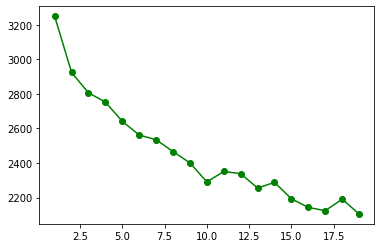

In [247]:
plt.plot(range(1,20),sse,"go-")

In [248]:
for k in range(20,41):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(ns_repr)
    sse.append(kmeans.inertia_)
    print(f"have done {k} rounds, current sse is {sse}")

have done 20 rounds, current sse is [3248.8134906840633, 2923.6338318348467, 2805.814595593956, 2752.4051663839477, 2640.6950001244845, 2561.885298676671, 2534.4111277541783, 2466.2465597156292, 2400.432176758721, 2290.606559387949, 2350.74840264635, 2338.3562118410537, 2254.962247743105, 2287.713112245516, 2192.995501674614, 2143.121024674409, 2123.8279286291704, 2190.752795516356, 2105.32846099011, 2056.834306608767]
have done 21 rounds, current sse is [3248.8134906840633, 2923.6338318348467, 2805.814595593956, 2752.4051663839477, 2640.6950001244845, 2561.885298676671, 2534.4111277541783, 2466.2465597156292, 2400.432176758721, 2290.606559387949, 2350.74840264635, 2338.3562118410537, 2254.962247743105, 2287.713112245516, 2192.995501674614, 2143.121024674409, 2123.8279286291704, 2190.752795516356, 2105.32846099011, 2056.834306608767, 1999.7451526220382]
have done 22 rounds, current sse is [3248.8134906840633, 2923.6338318348467, 2805.814595593956, 2752.4051663839477, 2640.6950001244845

have done 35 rounds, current sse is [3248.8134906840633, 2923.6338318348467, 2805.814595593956, 2752.4051663839477, 2640.6950001244845, 2561.885298676671, 2534.4111277541783, 2466.2465597156292, 2400.432176758721, 2290.606559387949, 2350.74840264635, 2338.3562118410537, 2254.962247743105, 2287.713112245516, 2192.995501674614, 2143.121024674409, 2123.8279286291704, 2190.752795516356, 2105.32846099011, 2056.834306608767, 1999.7451526220382, 1948.2396862571466, 1980.4790162780887, 1937.9688623765285, 1912.284361441527, 1906.6735371251389, 1826.650341622118, 1842.1802284364749, 1791.5211194496228, 1871.099014054583, 1732.9420275618093, 1736.4555250886028, 1733.5926293997752, 1691.140222435143, 1699.330143631499]
have done 36 rounds, current sse is [3248.8134906840633, 2923.6338318348467, 2805.814595593956, 2752.4051663839477, 2640.6950001244845, 2561.885298676671, 2534.4111277541783, 2466.2465597156292, 2400.432176758721, 2290.606559387949, 2350.74840264635, 2338.3562118410537, 2254.962247

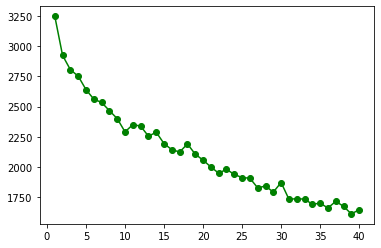

In [249]:
plt.plot(range(1,41),sse,"go-")

In [250]:
kl = KneeLocator(range(1,41), sse, curve="convex", direction="decreasing")

In [251]:
kl.elbow

10

**Using Silhouette Coefficient**

In [252]:
sc = []
new_sse = []
for k in range(2,51):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(ns_repr)
    score = silhouette_score(ns_repr, kmeans.labels_)
    sc.append(score)
    new_sse.append(kmeans.inertia_)
    print("step {}".format(k))

step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50


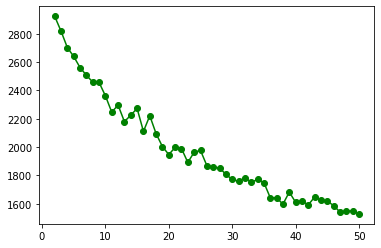

In [253]:
# for sse
plt.plot(range(2,51), new_sse, "go-")

In [254]:
kl_new = KneeLocator(range(2,51), new_sse, curve="convex", direction="decreasing")
kl_new.elbow

11

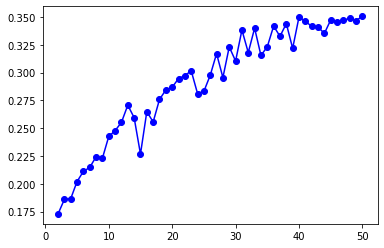

In [255]:
# for silhouette coefficient
plt.plot(range(2,51), sc, "bo-")

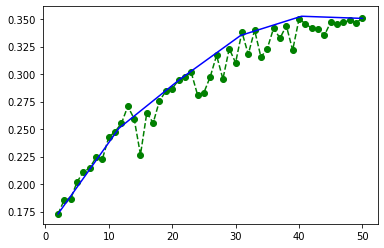

In [256]:


spl = make_interp_spline(range(2,51), sc, k=3)  # type: BSpline

xs = np.linspace(2, 50, 6)
ys = spl(xs)

plt.plot(range(2,51), sc, "go--")
plt.plot(xs, ys, "b-")

Let's choose k = 10

In [257]:
kmeans = KMeans(n_clusters = 10, init="k-means++", n_init = 50, max_iter = 500)
kmeans.fit(ns_repr)

KMeans(max_iter=500, n_clusters=10, n_init=50)

In [68]:
dir(kmeans)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_algorithm',
 '_check_feature_names',
 '_check_mkl_vcomp',
 '_check_n_features',
 '_check_params',
 '_check_test_data',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_init_centroids',
 '_more_tags',
 '_n_init',
 '_n_threads',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_tol',
 '_transform',
 '_validate_center_shape',
 '_validate_data',
 'algorithm',
 'cluster_centers_',
 'copy_x',
 'fit',
 'fit_predict',
 'fit_transform',
 'get_params',
 'inertia_',
 'init',
 'labels_',
 'max_iter',
 'n_clusters',
 'n_features_in_',
 'n_init',
 'n_iter_',
 'predict',
 'random_

In [258]:
kmeans.labels_

array([7, 0, 4, ..., 0, 0, 0])

In [259]:
set(kmeans.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [260]:
pca = PCA(n_components = 2)

In [261]:
pca_2d = pca.fit_transform(ns_repr)
pca_2d

array([[-0.15969581, -0.04042468],
       [-0.14587908, -0.04464958],
       [ 0.09121195,  0.1863071 ],
       ...,
       [-0.16333491, -0.04722984],
       [-0.16333491, -0.04722984],
       [-0.16333491, -0.04722984]])

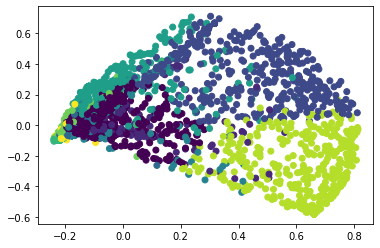

In [262]:
plt.scatter([v[0] for v in pca_2d], [v[1] for v in pca_2d], c = kmeans.labels_)

**Let's investigate each cluster**

In [263]:
news_sources = list(set(ns_subreddit.keys()) | set(ns_subreddit_feb.keys()) | set(ns_subreddit_march.keys()) | set(ns_subreddit_may.keys()) | set(ns_subreddit_jun.keys()))

In [264]:
len(news_sources)

4501

In [265]:
len(ns_sr_rep)

4638

In [267]:
set(ns_sr_rep.keys()) - set(news_sources)

{'1010xl.com',
 '1490wosh.com',
 '360tv.ru',
 '790business.com',
 '965kvki.com',
 'aksam.com.tr',
 'alfa.lt',
 'alliancemagazine.org',
 'am970theanswer.com',
 'anglicanjournal.com',
 'anna.aero',
 'apublicspace.org',
 'artribune.com',
 'arvopaperi.fi',
 'bakhtarnews.com.af',
 'baxterbulletin.com',
 'bluenc.com',
 'bomboradyo.com',
 'bradtguides.com',
 'brenhambanner.com',
 'brownsvilleherald.com',
 'capital.bg',
 'chinabusinessreview.com',
 'chly.ca',
 'concierto.cl',
 'country1053.ca',
 'cpbj.com',
 'crtvg.es',
 'ctee.com.tw',
 'cullmantimes.com',
 'dailytimes.com',
 'diariodenavarra.es',
 'diariosigloxxi.com',
 'duquoin.com',
 'elmoudjahid.com',
 'elpinguino.com',
 'espn1420.com',
 'freepressseries.co.uk',
 'galioninquirer.com',
 'gator995.com',
 'gazzettadiparma.it',
 'halesowennews.co.uk',
 'hbl.fi',
 'herald.ie',
 'hornfm.com',
 'idealhome.co.uk',
 'ifiberonenewsradio.com',
 'ildenaro.it',
 'jagonews24.com',
 'jazz.fm',
 'jeuxactu.com',
 'jewishtimes.com',
 'kanw.com',
 'kclu.org'

Let's make sure all news sources are in the `gmw_intersection`

In [268]:
with open('gmw_intersection.json', 'r', encoding='utf-8') as gmw_infile:
    gmw_intersection = json.load(gmw_infile)
    print(len(gmw_intersection))

6252


In [269]:
for ns in news_sources:
    if ns not in gmw_intersection:
        print(f"{ns} not in gmw_intersection")

In [270]:
len(kmeans.labels_)

4638

In [271]:
clustered = defaultdict(list)
for idx,ns in enumerate(ns_fixed):
    c = kmeans.labels_[idx]
    clustered[c].append(ns)

In [290]:
print([len(clustered[i]) for i in range(10)])

[2830, 93, 447, 58, 205, 246, 104, 124, 442, 89]


Let's see in terms of percentage

In [273]:
cluster_lens = [len(clustered[i]) for i in range(10)]

In [274]:
print([round(k*100/sum(cluster_lens),2) for k in cluster_lens])

[61.02, 2.01, 9.64, 1.25, 4.42, 5.3, 2.24, 2.67, 9.53, 1.92]


 **could do iterative clusters for ^**

In [275]:
clustered[0]

['247sports.com',
 'nikkei.com',
 'milenio.com',
 'animenewsnetwork.com',
 'crunchyroll.com',
 'barrons.com',
 'irishtimes.com',
 'infobae.com',
 'leaderpost.com',
 'oantagonista.com',
 'ign.com',
 'king5.com',
 'thestar.com',
 'mb.com.ph',
 'abc.net.au',
 'cbc.ca',
 'theverge.com',
 'deadline.com',
 'engadget.com',
 'linkedin.com',
 'billboard.com',
 'si.com',
 'natlawreview.com',
 'caranddriver.com',
 'pcmag.com',
 'nationalpost.com',
 'afr.com',
 'phys.org',
 'vancouverisland.ctvnews.ca',
 'toronto.ctvnews.ca',
 'smh.com.au',
 'vancouversun.com',
 'nsnews.com',
 'nzherald.co.nz',
 'brantfordexpositor.ca',
 'marketwatch.com',
 'biorxiv.org',
 'foxbangor.com',
 'kotaku.com',
 'buzzfeed.com',
 'giantbomb.com',
 'sfchronicle.com',
 'sportskeeda.com',
 'deccanchronicle.com',
 'variety.com',
 'out.com',
 'cheknews.ca',
 'newshub.co.nz',
 'kumparan.com',
 'medicalxpress.com',
 'zdnet.com',
 'pitchfork.com',
 'bitcoinmagazine.com',
 'dexerto.com',
 'anchor.fm',
 'kiplinger.com',
 'archdaily

Cluster 0 has a lot of Asian news sources

In [276]:
clustered[1]

['breitbart.com',
 'foxnews.com',
 'dailycaller.com',
 'lifesitenews.com',
 'realclearpolitics.com',
 'commentarymagazine.com',
 'hotair.com',
 'newsbusters.org',
 'thepostmillennial.com',
 'washingtonexaminer.com',
 'foxbusiness.com',
 'newsmax.com',
 'theblaze.com',
 'dailywire.com',
 'oann.com',
 'americanthinker.com',
 'zerohedge.com',
 'redstate.com',
 'justthenews.com',
 'pjmedia.com',
 'westernjournal.com',
 'nationalinterest.org',
 'townhall.com',
 'thefederalist.com',
 'thetruthaboutguns.com',
 'burlingtonfreepress.com',
 'kake.com',
 'humanevents.com',
 'mooresvilletribune.com',
 'wbap.com',
 'kpax.com',
 'kelo.com',
 'thv11.com',
 'twitchy.com',
 'spiked-online.com',
 'freebeacon.com',
 'cnsnews.com',
 'dailysignal.com',
 'weau.com',
 'campusreform.org',
 'frontpagemag.com',
 'quillette.com',
 'whtc.com',
 'usni.org',
 'christianpost.com',
 'mndaily.com',
 'wflx.com',
 'outkick.com',
 'skynews.com.au',
 'thecollegefix.com',
 'realscreen.com',
 'powerlineblog.com',
 'bravewor

Cluster 1 not sure about what

In [277]:
clustered[2]

['cnbc.com',
 'abc7chicago.com',
 'kmov.com',
 'wtop.com',
 'nbcnews.com',
 'cbsnews.com',
 'boston.com',
 'yahoo.com',
 'wbng.com',
 'nbclosangeles.com',
 'military.com',
 'hawaiinewsnow.com',
 'gizmodo.com',
 'mauinews.com',
 'kutv.com',
 'mynbc15.com',
 'nbc12.com',
 'whdh.com',
 'kxxv.com',
 'manilastandard.net',
 'oregonlive.com',
 'fox13now.com',
 'sciencebasedmedicine.org',
 'kptv.com',
 'pennlive.com',
 'nj.com',
 'wktv.com',
 'cbs19.tv',
 'nbcwashington.com',
 'journalstar.com',
 'fox5dc.com',
 'localmemphis.com',
 'wmcactionnews5.com',
 'ctpost.com',
 'ksat.com',
 'nj1015.com',
 'cnet.com',
 'wtol.com',
 '5newsonline.com',
 'abc7ny.com',
 'niemanlab.org',
 'kktv.com',
 'click2houston.com',
 'wral.com',
 '1011now.com',
 '8newsnow.com',
 'krem.com',
 'khq.com',
 'ktvu.com',
 'abc7news.com',
 'fastcompany.com',
 'kitchener.ctvnews.ca',
 'abc13.com',
 'dailyvoice.com',
 'kob.com',
 '6abc.com',
 'krcrtv.com',
 'wlos.com',
 'koco.com',
 'mlive.com',
 'wfaa.com',
 '10news.com',
 'fo

Cluster 2 has some big names & TV (cnn.com, npr.org, etc)

In [278]:
clustered[3]

['ilfattoquotidiano.it',
 'corriere.it',
 'ansa.it',
 'ilpost.it',
 'ilgiorno.it',
 'repubblica.it',
 'today.it',
 'tgcom24.mediaset.it',
 'lastampa.it',
 'fanpage.it',
 'adnkronos.com',
 'huffingtonpost.it',
 'leggo.it',
 'tg24.sky.it',
 'ilmessaggero.it',
 'ilsole24ore.com',
 'tomshw.it',
 'la7.it',
 'rainews.it',
 'giornaledibrescia.it',
 'tpi.it',
 'espresso.repubblica.it',
 'iltempo.it',
 'avvenire.it',
 'agi.it',
 'gds.it',
 'ilfoglio.it',
 'rai.it',
 'wired.it',
 'lagazzettadelmezzogiorno.it',
 'qds.it',
 'ilrestodelcarlino.it',
 'corrieredellumbria.corr.it',
 'ilsecoloxix.it',
 'linkiesta.it',
 'ilmattino.it',
 'internazionale.it',
 'blitzquotidiano.it',
 'ecodibergamo.it',
 'ladige.it',
 'ilgiornaledivicenza.it',
 'wallstreetitalia.com',
 'quattroruote.it',
 'lanazione.it',
 'gazzettadelsud.it',
 'quotidiano.net',
 'vogue.it',
 'napolitoday.it',
 'larena.it',
 'tempi.it',
 'altoadige.it',
 'artribune.com',
 'mattinopadova.gelocal.it',
 'primaonline.it',
 'domusweb.it',
 'iltir

Cluster 3 has 60% of tthe news sources. **use MBFC/PAB for scores to make sense of these**

In [279]:
clustered[4]

['webmd.com',
 'livescience.com',
 'newscientist.com',
 'statista.com',
 'inc.com',
 'designboom.com',
 'atlasobscura.com',
 'healthline.com',
 'womenshealthmag.com',
 'honolulumagazine.com',
 'treehugger.com',
 'popularmechanics.com',
 'ultimateclassicrock.com',
 'malaysiakini.com',
 'foodandwine.com',
 'loudwire.com',
 'snopes.com',
 'scientificamerican.com',
 'popsci.com',
 'discovermagazine.com',
 'pjstar.com',
 'moneysavingexpert.com',
 'thecoast.ca',
 'additudemag.com',
 'mentalfloss.com',
 'medlineplus.gov',
 'sciencedaily.com',
 'iflscience.com',
 'dailynorthwestern.com',
 'cracked.com',
 'bostonmagazine.com',
 'songfacts.com',
 'bhg.com',
 'apartmenttherapy.com',
 'lifehacker.com',
 'classicfm.com',
 'consumerreports.org',
 'kexp.org',
 'eater.com',
 'stlmag.com',
 'washingtoncitypaper.com',
 'kerrang.com',
 'epicurious.com',
 'hyperallergic.com',
 'modernfarmer.com',
 'highsnobiety.com',
 'olympicchannel.com',
 'jezebel.com',
 'houstonpress.com',
 'americansongwriter.com',
 '

Cluster 4 has news sources from DE, AT, CH

In [280]:
clustered[5]

['aljazeera.com',
 'bbc.co.uk',
 'reuters.com',
 'upi.com',
 'gulfnews.com',
 'bangkokpost.com',
 'scmp.com',
 '9news.com.au',
 'ctvnews.ca',
 'japantoday.com',
 'thehimalayantimes.com',
 'nepalitimes.com',
 'koreaherald.com',
 'sbs.com.au',
 'tribune.com.pk',
 'economist.com',
 'japantimes.co.jp',
 'news.com.au',
 'trtworld.com',
 'khmertimeskh.com',
 'dailysabah.com',
 'ibtimes.com',
 'business-standard.com',
 'siasat.com',
 'thediplomat.com',
 'gulftoday.ae',
 'kfgo.com',
 'euobserver.com',
 'theweek.co.uk',
 'rudaw.net',
 'thestar.com.my',
 'tradewindsnews.com',
 'themoscowtimes.com',
 'tolonews.com',
 'rferl.org',
 'malaymail.com',
 'haaretz.com',
 'express.co.uk',
 'hindustantimes.com',
 'en.people.cn',
 'pri.org',
 'entrepreneur.com',
 'news24.com',
 'yle.fi',
 'freemalaysiatoday.com',
 'qz.com',
 'republicworld.com',
 'wellandtribune.ca',
 'africanews.com',
 'iol.co.za',
 'ynet.co.il',
 'dr.dk',
 'politico.eu',
 'assamtribune.com',
 'allafrica.com',
 'mybroadband.co.za',
 'vall

Lots of international outlets, including Asian countries, AU, UK 
**show the features contributing the most (use Naive Bayes), or show the subreddits that they share**

In [281]:
clustered[6]

['leparisien.fr',
 'ledevoir.com',
 'touteleurope.eu',
 'lemonde.fr',
 '20minutes.fr',
 'franceinter.fr',
 'bfmtv.com',
 'developpez.com',
 'lepoint.fr',
 'lesechos.fr',
 'actu.fr',
 'huffingtonpost.fr',
 'publicsenat.fr',
 'lefigaro.fr',
 'francetvinfo.fr',
 'krytykapolityczna.pl',
 'nicematin.com',
 'rtbf.be',
 'lavoixdunord.fr',
 'letelegramme.fr',
 'madmoizelle.com',
 'lepopulaire.fr',
 'futura-sciences.com',
 'arte.tv',
 'la-croix.com',
 'jeuxvideo.com',
 'lepetitjournal.com',
 'lnc.nc',
 'lci.fr',
 'paris-normandie.fr',
 'europe1.fr',
 'rtl.fr',
 'laprovence.com',
 'journaldunet.com',
 'monde-diplomatique.fr',
 'sudouest.fr',
 'france3-regions.francetvinfo.fr',
 'courrierinternational.com',
 'cnews.fr',
 'midilibre.fr',
 'lcp.fr',
 'lyoncapitale.fr',
 'businessinsider.fr',
 'journaldugeek.com',
 'tf1.fr',
 'franceculture.fr',
 'tdg.ch',
 'alternatives-economiques.fr',
 'france.tv',
 'tetu.com',
 'tomsguide.fr',
 'femmeactuelle.fr',
 'humanite.fr',
 'gala.fr',
 'numerama.com',
 '0

cluster 6 has some sport ones

In [282]:
clustered[7]

['espn.com',
 'skysports.com',
 'telegraph.co.uk',
 'yna.co.kr',
 'football.london',
 'as.com',
 'nrk.no',
 'theathletic.com',
 'luzernerzeitung.ch',
 'abola.pt',
 'dailyrecord.co.uk',
 'thestar.co.uk',
 'sportingnews.com',
 'gazzetta.it',
 'corrieredellosport.it',
 'watfordobserver.co.uk',
 'jyllands-posten.dk',
 'cadenaser.com',
 'thesportreview.com',
 'kicker.de',
 'bild.de',
 'mirror.co.uk',
 'the42.ie',
 'fourfourtwo.com',
 '24sata.hr',
 'vg.no',
 'pressandjournal.co.uk',
 'haberler.com',
 'haberturk.com',
 'telegraaf.nl',
 'liverpoolecho.co.uk',
 'ojogo.pt',
 'sabah.com.tr',
 'manchestereveningnews.co.uk',
 'rtp.pt',
 'standard.co.uk',
 'tsf.pt',
 'observador.pt',
 'leicestermercury.co.uk',
 'lep.co.uk',
 'birminghammail.co.uk',
 'idnes.cz',
 'marca.com',
 'expressandstar.com',
 'espn.com.br',
 'chroniclelive.co.uk',
 'jn.pt',
 'glasgowtimes.co.uk',
 'sportske.jutarnji.hr',
 'talksport.com',
 'bristolpost.co.uk',
 'mundodeportivo.com',
 'weekendavisen.dk',
 'bournemouthecho.co.uk

cluster 7 has FR news outlets

In [283]:
clustered[8]

['thehill.com',
 'thedailybeast.com',
 'jsonline.com',
 'fivethirtyeight.com',
 'newsweek.com',
 'nytimes.com',
 'stripes.com',
 'kvia.com',
 'cnn.com',
 'civilbeat.org',
 'ksnblocal4.com',
 'apnews.com',
 'ajc.com',
 'washingtonpost.com',
 'triblive.com',
 'lawandcrime.com',
 'npr.org',
 'texastribune.org',
 'politico.com',
 'al.com',
 'startribune.com',
 'krdo.com',
 'houstonchronicle.com',
 'talkingpointsmemo.com',
 'abc17news.com',
 'militarytimes.com',
 'sltrib.com',
 'whyy.org',
 'localnews8.com',
 'kjrh.com',
 'independent.co.uk',
 'latimes.com',
 'thehour.com',
 'chicagotribune.com',
 'newrepublic.com',
 'baltimoresun.com',
 'roanoke.com',
 'sacbee.com',
 'hawaiipublicradio.org',
 'msnbc.com',
 'vox.com',
 'mediaite.com',
 'grandforksherald.com',
 'pressconnects.com',
 'nextgov.com',
 'ktvz.com',
 'wqad.com',
 'timesunion.com',
 'federalnewsnetwork.com',
 'pbs.org',
 'buzzfeednews.com',
 'slate.com',
 'oklahoman.com',
 'naplesnews.com',
 'freep.com',
 'nymag.com',
 'wbur.org',


Cluster 8 has 'learning' stuff like for health, history, business, etc.

In [284]:
clustered[9]

['stern.de',
 'tagesschau.de',
 'sueddeutsche.de',
 'tagesanzeiger.ch',
 'derbund.ch',
 'nzz.ch',
 'spiegel.de',
 'derstandard.at',
 'srf.ch',
 'stadt-bremerhaven.de',
 'orf.at',
 'flugrevue.de',
 'welt.de',
 'wiwo.de',
 'golem.de',
 'taz.de',
 'stuttgarter-nachrichten.de',
 'focus.de',
 'rp-online.de',
 'tagesspiegel.de',
 'br.de',
 'faz.net',
 'morgenpost.de',
 'futurezone.at',
 'mdr.de',
 'kurier.at',
 'tag24.de',
 'pcwelt.de',
 'n-tv.de',
 'ndr.de',
 'heise.de',
 '20min.ch',
 'merkur.de',
 'heute.at',
 'derwesten.de',
 'rnd.de',
 'freitag.de',
 't-online.de',
 'nau.ch',
 'handelsblatt.com',
 'nzzas.nzz.ch',
 'chip.de',
 'badische-zeitung.de',
 'diepresse.com',
 'prosieben.de',
 'jungefreiheit.de',
 'nachrichten.at',
 'neues-deutschland.de',
 'fm4.orf.at',
 'infranken.de',
 'waz.de',
 'autobild.de',
 'jungewelt.de',
 'thueringer-allgemeine.de',
 'maz-online.de',
 'saarbruecker-zeitung.de',
 'tt.com',
 'mz-web.de',
 'ksta.de',
 'nordbayern.de',
 'haz.de',
 'krone.at',
 'geo.de',
 'mo

A lot of local news sources and TV stations

**hierarchical clusterings** now that we have small groups (within clusters)

In [285]:
for ii in range(12):
    if "breitbart.com" in clustered[ii]:
        print("breitbart in cluster", ii )

breitbart in cluster 1


In [286]:
for ii in range(12):
    if "foxnews.com" in clustered[ii]:
        print("foxnews in cluster", ii )

foxnews in cluster 1


In [291]:
print(clustered.keys())

dict_keys([7, 0, 4, 8, 1, 2, 5, 9, 6, 3, 10, 11])


In [294]:
clustered_new = dict()
for ii in range(10):
    clustered_new[ii] = clustered[ii]

Let's write these clusterings into a file.

In [296]:
with open("kmeans_clusters.json", "w", encoding = "utf-8") as outfile:
    json.dump(clustered_new, outfile, indent = 4)

## Preliminary findings:

1. Even with just the list of subreddits for each news source, we are able to generate rather meaningful clusterings with k-means.
2. This clustering tells us much about the various origin/domain of news sources (US, UK, Germany/Switzerland/UK, France/Switzerland, India) and affiliation (Gray), topics, but not political leanings (e.g. Foxnews and Breitbart are not in the same cluster).

**Next steps:**
1. Try out different clustering algorithm (i.e. since k-means are intended for radially distributed data, try other algorithms like DBSCAN which is based on density, and other ones).
2. Add more data from other months.
3. For features, in addition to appearance count in each subreddit, add also the description of subreddits? *Q*: Which subreddit desciptions should I add? Maybe I should use subreddit description for clustering subreddits.
4. Think about how to describe each cluster! [Explainable AI?!]

In [32]:
2572/3686

0.6977753662506783

**Nov 4**

I am curious if how the number of news sources in each cluster would change if I add more clusters, since 1 cluster out of 12 contains almost 70% of the news sources

In [34]:
kmeans_k20 = KMeans(n_clusters = 20, init="k-means++", n_init = 50, max_iter = 500)
kmeans_k20.fit(ns_repr)

KMeans(max_iter=500, n_clusters=20, n_init=50)

In [35]:
# k = 20
clustered_k20 = defaultdict(list)
for idx,ns in enumerate(ns_fixed):
    c = kmeans_k20.labels_[idx]
    clustered_k20[c].append(ns)

In [37]:
print([len(clustered_k20[i]) for i in range(20)])

[36, 45, 79, 39, 27, 53, 104, 223, 196, 99, 20, 108, 102, 2274, 33, 46, 69, 24, 48, 61]


This seems more evenly distributed than the 12 clusters version. However, one cluster still has 2274/3686 news sources.

In [40]:
print([round(len(clustered_k20[i])*100/len(ns_subreddit),2) for i in range(20)])

[0.98, 1.22, 2.14, 1.06, 0.73, 1.44, 2.82, 6.05, 5.32, 2.69, 0.54, 2.93, 2.77, 61.69, 0.9, 1.25, 1.87, 0.65, 1.3, 1.65]


This suggests that either a different clustering method should be used, or we need more features to do the clustering.

## DBSCAN clustering

In [41]:
from sklearn.cluster import DBSCAN

First try out.

In [56]:
dbscan = DBSCAN(eps=0.01)

In [57]:
ds_clusters = dbscan.fit(ns_repr)

In [58]:
dbs_labels = ds_clusters.labels_
len(dbs_labels)

3686

In [59]:
np.unique(dbs_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64)

In [60]:
dbscan_clusters = defaultdict(list)
for idx, c in enumerate(list(dbs_labels)):
    dbscan_clusters[c].append(ns_fixed[idx])

In [62]:
for c in range(-1, 10):
    print("number of ns in cluster {}: {}".format(c, len(dbscan_clusters[c])))

number of ns in cluster -1: 3589
number of ns in cluster 0: 31
number of ns in cluster 1: 6
number of ns in cluster 2: 5
number of ns in cluster 3: 14
number of ns in cluster 4: 7
number of ns in cluster 5: 7
number of ns in cluster 6: 5
number of ns in cluster 7: 6
number of ns in cluster 8: 7
number of ns in cluster 9: 9


Let's investigate some of the clusters

In [63]:
dbscan_clusters[0]

['alaskahighwaynews.ca',
 'mywestnipissingnow.com',
 'paherald.sk.ca',
 'bowenislandundercurrent.com',
 'heralddemocrat.com',
 'country94.ca',
 'kincardinenews.com',
 'lockportjournal.com',
 'saultthisweek.com',
 'zoomerradio.ca',
 'stargazette.com',
 'cadillacnews.com',
 'myespanolanow.com',
 'queensjournal.ca',
 'wokq.com',
 'amarillo.com',
 'krbd.org',
 'theconcordian.com',
 'newsdakota.com',
 'newstalkkit.com',
 'kdal610.com',
 'examiner-enterprise.com',
 'northernnews.ca',
 'pembinavalleyonline.com',
 'thejewishnews.com',
 'nonpareilonline.com',
 'mindentimes.ca',
 'vvdailypress.com',
 'ksut.org',
 'qctonline.com',
 'q1065.fm']

In [64]:
dbscan_clusters[1]

['ibahia.com',
 'bahianoticias.com.br',
 'hojeemdia.com.br',
 'diariodepernambuco.com.br',
 'catracalivre.com.br',
 'jb.com.br']

In [65]:
dbscan_clusters[2] # Deutsche

['pcwelt.de', 'bernerzeitung.ch', 'dwdl.de', 'cicero.de', 'autozeitung.de']

In [66]:
dbscan_clusters[3]

['beachwoodreporter.com',
 'montanakaimin.com',
 'athensreview.com',
 'argusobserver.com',
 'wmra.org',
 'catholicsun.org',
 'wkvi.com',
 'insidetime.org',
 'journalpatriot.com',
 'waer.org',
 'mpbonline.org',
 'wclk.com',
 'hudsonreporter.com',
 'commonwealthtimes.org']

In [67]:
dbscan_clusters[4]

['wfxb.com',
 'tyt.com',
 'kawc.org',
 'blackchronicle.com',
 'cleburnetimesreview.com',
 'emaratalyoum.com',
 'neoshodailynews.com']

In [68]:
dbscan_clusters[5]

['okgazette.com',
 'good.is',
 'nationaltrust.org.uk',
 'lady.co.uk',
 'wcsx.com',
 'truewestmagazine.com',
 '1045wjjk.com']

In [69]:
dbscan_clusters[6]

['cnbeta.com',
 'orientaldaily.com.my',
 'radionacional.com.ar',
 'singtao.ca',
 'donews.com']

In [70]:
dbscan_clusters[7]

['tomsguide.fr',
 'femmeactuelle.fr',
 'gamekult.com',
 '24heures.ch',
 'lematin.ch',
 'liberte-algerie.com']

In [71]:
dbscan_clusters[8]

['thefloridacatholic.org',
 'lanthorn.com',
 'newjerseyhills.com',
 'wbkb11.com',
 'leaderherald.com',
 'meadvilletribune.com',
 'hotelmanagement.net']

In [72]:
dbscan_clusters[9]

['telemundoatlanta.com',
 'elsoldedurango.com.mx',
 'elsoldetulancingo.com.mx',
 'unomasuno.com.mx',
 'elmercurio.com.mx',
 'diariodequeretaro.com.mx',
 'wradio.com.mx',
 'elvigia.net',
 'hidrocalidodigital.com']

**Finding optimum `epsilon` for dbscan**

References: 

https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

In [74]:
from sklearn.neighbors import NearestNeighbors

In [75]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(ns_repr)
distances, indices = nbrs.kneighbors(ns_repr)

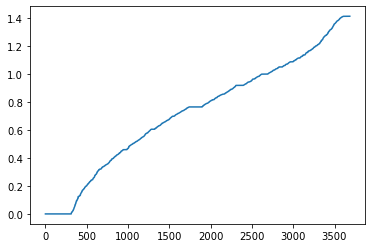

In [84]:
distances = np.sort(distances, axis=0)
# distances = distances[:,1]
plt.plot(distances)
# plt.ylim((0,0.000025))

I don't think any epsilon makes sense here.